# Generalization 
# UNet with 3 encoder-decoder blocks trained on 80x80 CelebA images 

In [79]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
import matplotlib.pylab as plt
import matplotlib.colors as colors
import torch
from torch.utils.data import DataLoader

import os
import time                   
import sys
import argparse 

sys.path.insert(0, '../code') 
from network import UNet
from model_loader_func import load_UNet
from plotting_func import plot_many_denoised,  show_im_set, plot_single_im
from quality_metrics_func import calc_psnr, im_set_corr
from linear_approx import calc_jacobian, traj_projections
from inverse_tasks_func import synthesis
from algorithm_inv_prob import univ_inv_sol
from dataloader_func import add_noise_torch

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
print(torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

1.13.1+cpu


device(type='cpu')

## Load denoisers


In [82]:
## Load pretraiend denoisers 

denoisers_face = {}
# denoisers in group A are trained on one partision of the data which is non-overlapping with partision B
groups = ['A', 'B'] 
swap = False
training_data_name = 'train40x40_no_repeats'

Ns = [10,100,1000, 10000,98117] #size of the dataset 

for group in groups: 
    print('loading group ' , group )
    denoisers_face[group] = {}
    if group == 'B': 
        swap = True
    for N in Ns:       
        start_time_total = time.time()        
        try: 
            denoisers_face[group][N] = load_UNet(
                           base_path = '../denoisers/UNet',
                           training_data_name= training_data_name, 
                           training_noise='0to255',
                           RF=90,
                           set_size=N, 
                           swap=swap);
        except FileNotFoundError: 
            pass 
        print("--- %s seconds ---" % (round(time.time() - start_time_total)))


loading group  A
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
loading group  B
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---


In [83]:
denoisers_face['A'].keys()

dict_keys([10, 100, 1000, 10000, 98117])

## Load datasets 

In [85]:
###### Before running this cell, down the dataset from ??? into the datasets/img_align_celeba/ folder.
###### Dataset consist of CelebA images cropped to 160x160 and then downsampled to 80x80.
###### The RGB channels have been averaged to create grayscale images 

train_face ={}
test_face = {}
train_face['A'] = {}
train_face['B'] ={}
test_face['B'] = {}
test_face['A'] = {}

Ns = [10,100,1000, 10000,98117]

data = torch.load('../datasets/train40x40_no_repeats.pt')
K = data.shape[2] 
print(data.shape)
for N in Ns:
    train_face['A'][N] = data[0:N]
    test_face['A'][N] = data[-N::]
    train_face['B'][N] = data[-N::]
    test_face['B'][N] = data[0:N]   
    
     

torch.Size([196235, 1, 40, 40])


In [86]:
## rename N=99325 with N=100000 for ease of use later 
## Do not run this cell twice! 

denoisers_face['A'][100000] = denoisers_face['A'][98117]
del denoisers_face['A'][98117]   
denoisers_face['B'][100000] = denoisers_face['B'][98117]
del denoisers_face['B'][98117]  

train_face['A'][100000] = train_face['A'][98117]
del train_face['A'][98117]   
train_face['B'][100000] = train_face['B'][98117]
del train_face['B'][98117]  

test_face['A'][100000] = test_face['A'][98117]
del test_face['A'][98117]   
test_face['B'][100000] = test_face['B'][98117]
del test_face['B'][98117]

Ns = list(denoisers_face['A'].keys())
print(Ns)

[10, 100, 1000, 10000, 100000]


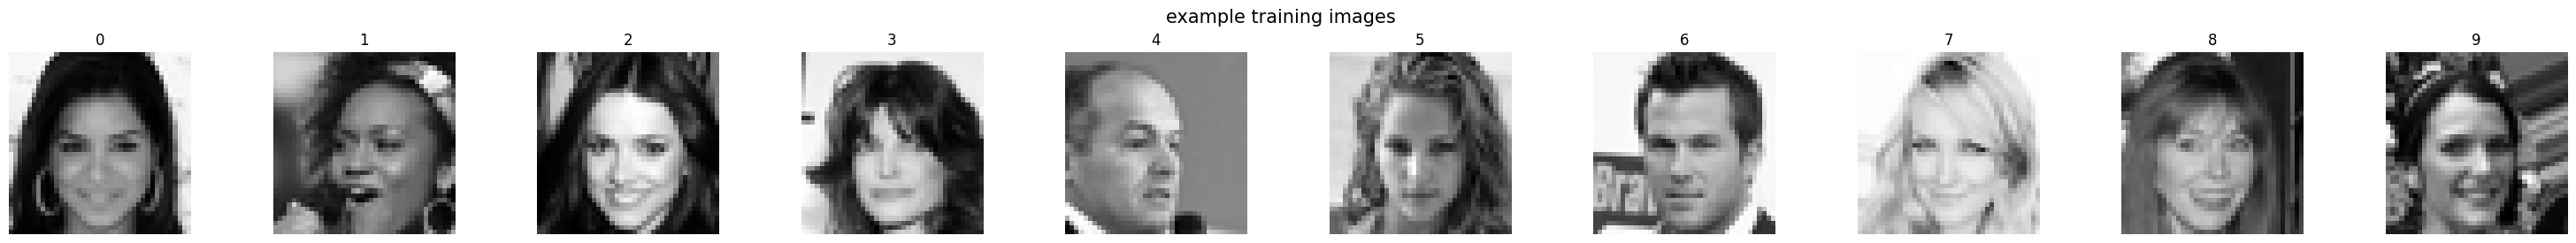

In [87]:
show_im_set(train_face['A'][10][0:10], n_columns=10, label='example training images')

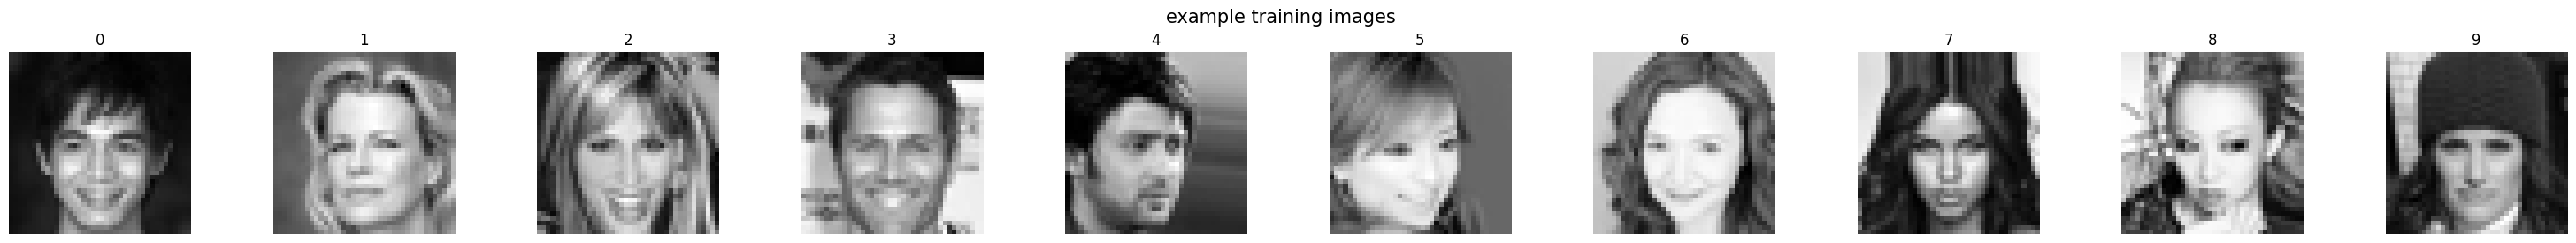

In [8]:
show_im_set(train_face['B'][10][0:10], n_columns=10, label='example training images')

# One shot denoising 

In [9]:
## compute psnr on test and train sets as a function of train set size N
sig_range = torch.logspace(.3,2.4,15)
psnr_test = {}
psnr_train = {}
for group in groups: 
    psnr_test[group] = {}
    psnr_train[group] = {}
    for N in Ns: 
        ## train 
        data = train_face[group][N]
        if N <300: 
            data = torch.tile(data, dims=(int(300/N) , 1,1,1))
        else: 
            data = data[0:300]        

        loader = DataLoader(dataset=data, batch_size=300, shuffle=False)
        try:
            print(N)
            psnr_train[group][N] = calc_psnr(denoisers_face[group][N],loader,sig_range , device)
        except KeyError: 
            pass

        ## test 
        data = test_face[group][1000][0:300]    
        loader = DataLoader(dataset=data, batch_size=300, shuffle=False)    
        try: 
            psnr_test[group][N] = calc_psnr(denoisers_face[group][N],loader,sig_range, device)
        except KeyError: 
            pass


10
100
1000
10000
100000
10
100
1000
10000
100000


10
100
1000
10000
100000


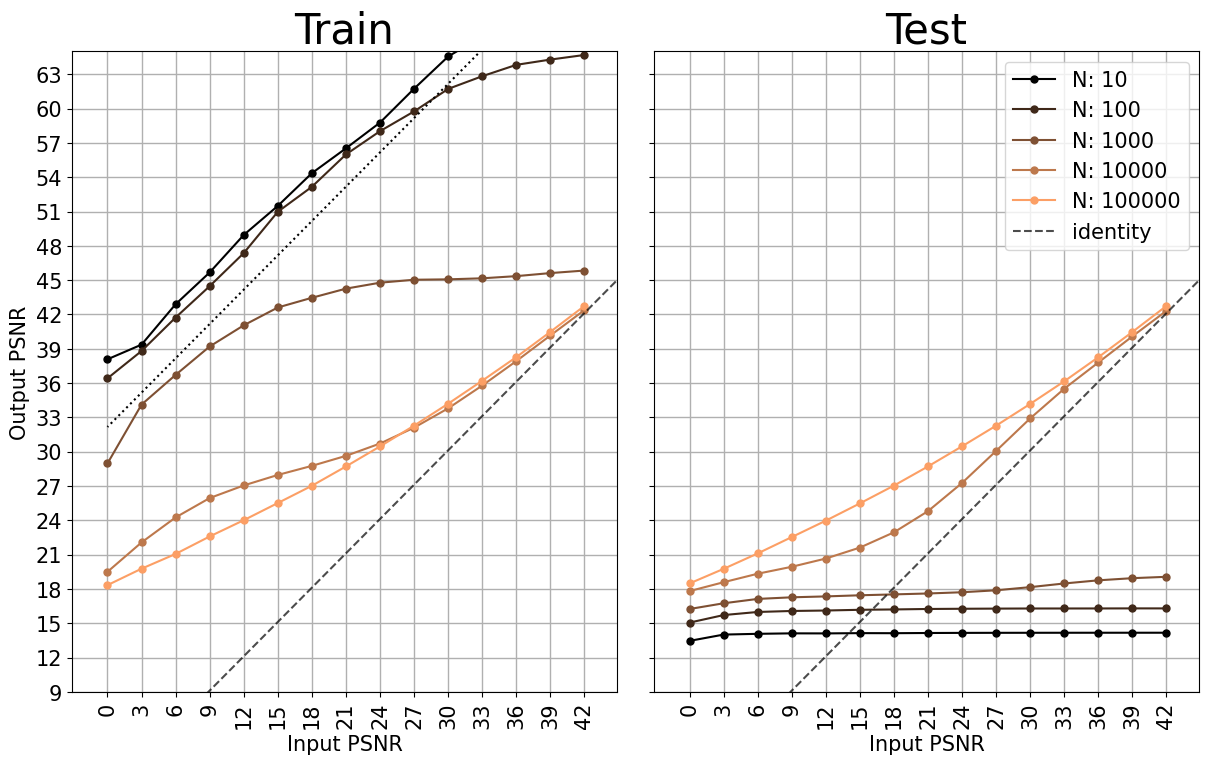

In [11]:
## plot 
group = 'B'
f , axs = plt.subplots(1,2, figsize=(12,7), sharex = True, sharey=True)
plt.tight_layout()
x_axis = [ -10*np.log10( (float(std)/255)**2  ) for std in psnr_train[group][1000].keys()]

for N in [10,100,1000,10000, 100000]: 
    print(N)
    ## train 
    axs[0].plot(x_axis, [psnr_train[group][N][key] for key in psnr_train[group][N].keys()], 
                marker = '.',markersize = 10, alpha = 1,label = 'N: '+ str(N))

    ## test 
    axs[1].plot(x_axis, [psnr_test[group][N][key] for key in psnr_test[group][N].keys()], 
                marker = '.',markersize = 10,label = 'N: '+ str(N), alpha = 1)
for i in range(2):
    axs[i].set_xticks(x_axis);
    axs[i].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=15)
    axs[i].set_xlim(-3, 45)
    
    axs[i].set_yticks(range(9,65,3) );    
    axs[i].set_yticklabels(range(9,65,3), fontsize=15);
    axs[i].set_ylim(9, 65)
    
    axs[i].grid(  linewidth=1);
    
    colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
    plot_colors = [colormap(i) for i in np.linspace(0, 1,len(Ns)+1)]
    for k,j in enumerate(axs[i].lines):
        j.set_color(plot_colors[k])
axs[0].plot(x_axis, [ -10*np.log10( (std/255)**2  ) for std in sig_range/K ],linestyle = 'dotted', color='black')
axs[0].plot( [0,65],[0,65] ,'k--', alpha = .7, label = 'identity');
axs[1].plot( [0,65],[0,65] ,'k--', alpha = .7, label = 'identity');

axs[1].legend(fontsize = 15);
axs[0].set_title('Train', fontsize = 30)
axs[1].set_title('Test', fontsize = 30)
axs[0].set_xlabel('Input PSNR', fontsize = 15)
axs[0].set_ylabel('Output PSNR', fontsize = 15);
axs[1].set_xlabel('Input PSNR', fontsize = 15);


# denoise the same image once as the train image and once as the test image

In [24]:
### pick N 
N = 100000

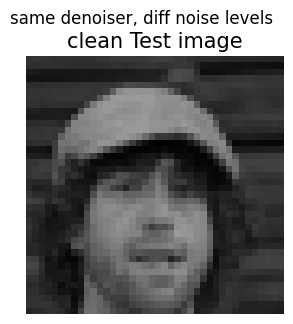

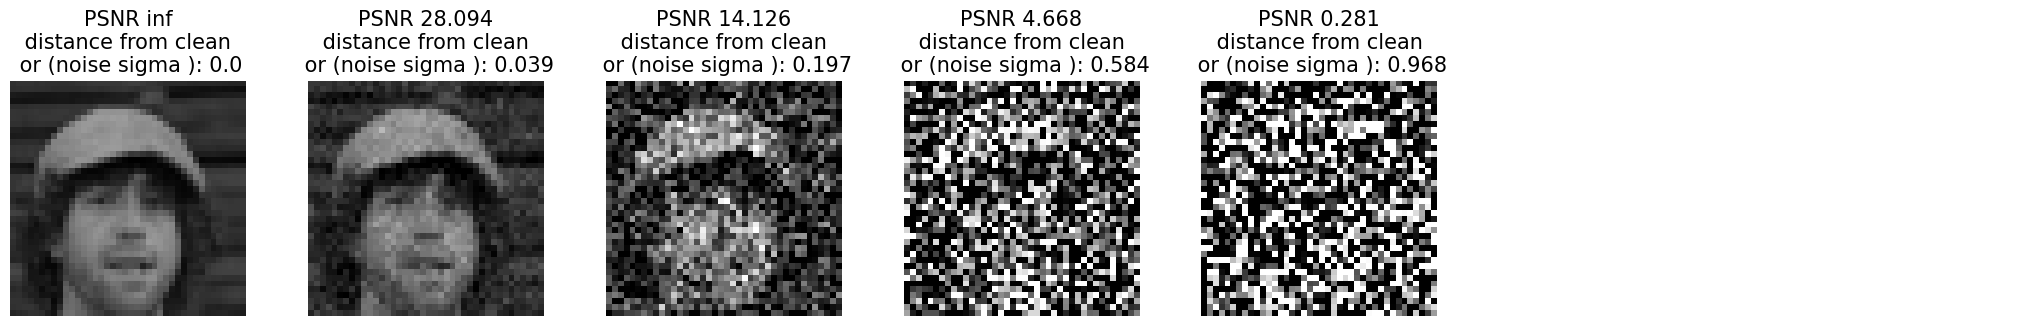

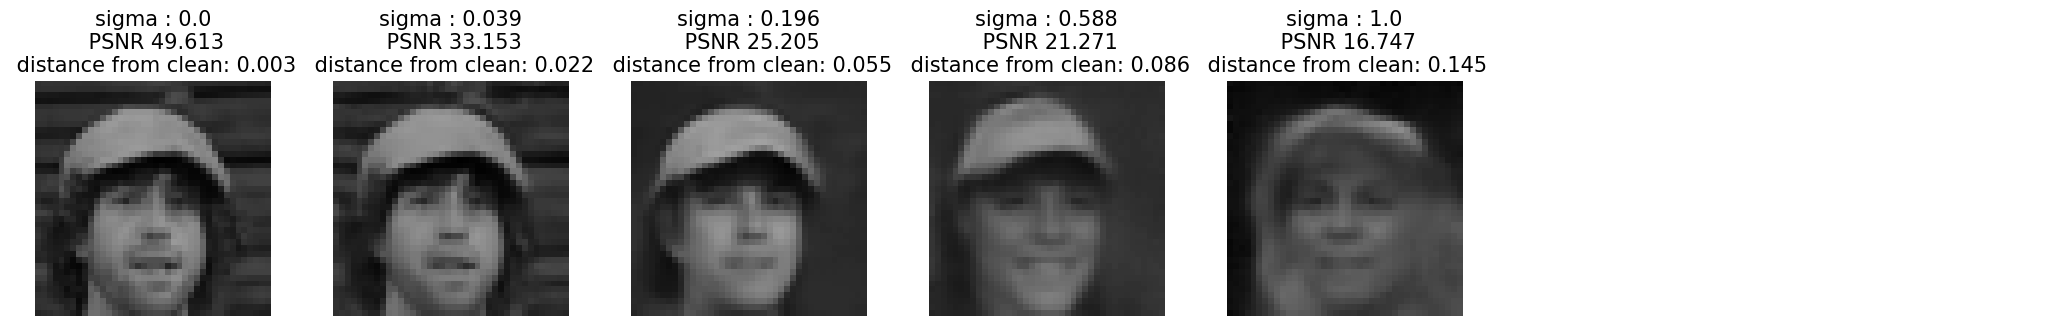

In [25]:
### denoise the same test image with different levels of noise using denoisers in the same group 

all_train_A_denoised = {}
all_noisy = {}

n = 0 # im number (must be smaller than N)
im = test_face['A'][N][n:n+1]

sigmas = torch.tensor([0,10,50,150, 255])
with torch.no_grad():
    for s in sigmas:
        s = np.round(s.item())
        noisy , _ = add_noise_torch( im , s )
        all_noisy[s] = noisy
        denoised_im = noisy.to(device) - denoisers_face['A'][N](noisy.to(device)).detach()
        
        all_train_A_denoised[np.round(s/255, 3)] = denoised_im
        if N ==1:
            print('expected distance: ', str(s/255/80 ))
### plot
plot_many_denoised(im, all_noisy, all_train_A_denoised ,device, 
                   suptitle = 'same denoiser, diff noise levels ', 
                   label='sigma : ', train= False, vmin=0, vmax=1, im_size=3)



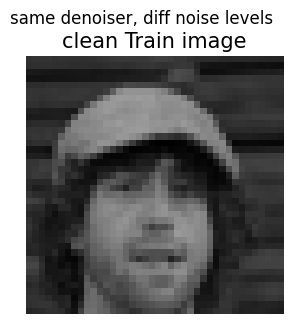

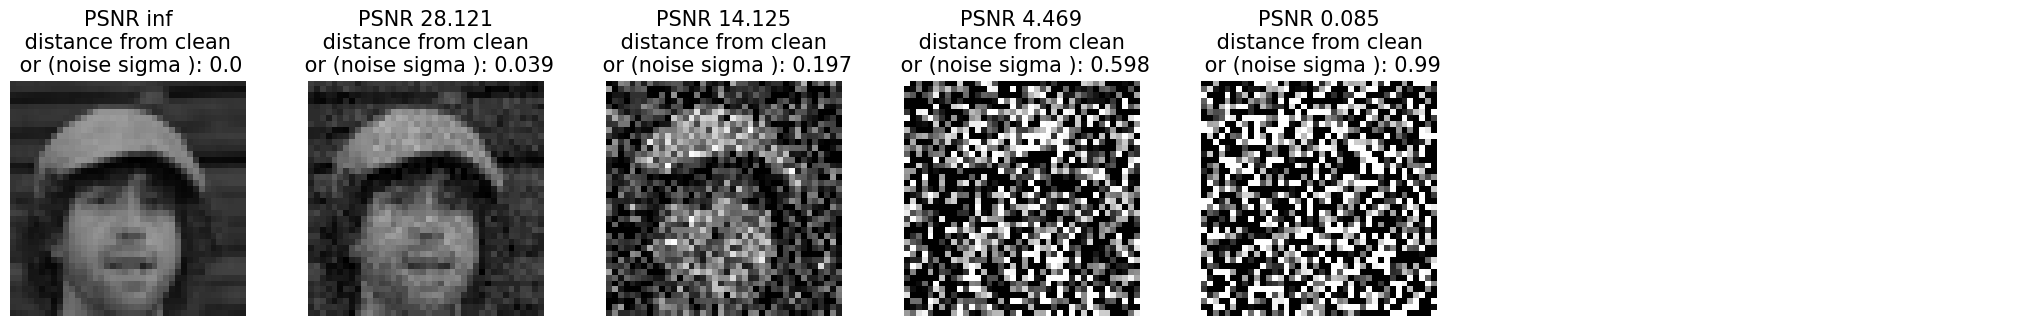

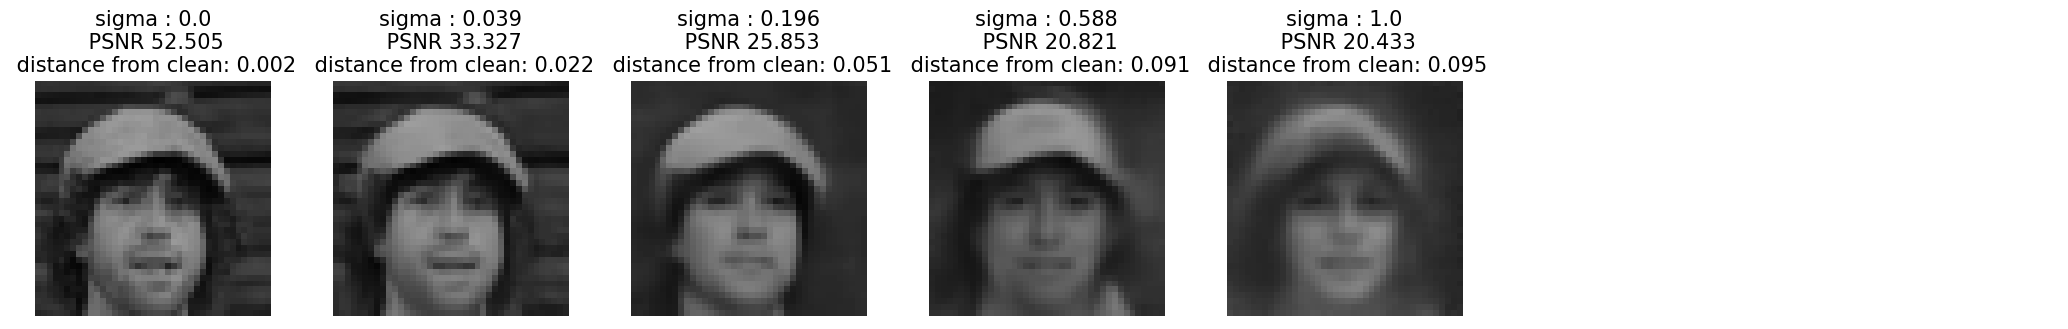

In [26]:
### Now the same image is a train image for denoisers in group B
### Performance on the same image when it is a train image 
all_train_A_denoised = {}
all_noisy = {}


sigmas = torch.tensor([0,10,50,150, 255])
with torch.no_grad():
    for s in sigmas:
        s = np.round(s.item())
        noisy , _ = add_noise_torch( im , s )
        all_noisy[s] = noisy
        denoised_im = noisy.to(device)-denoisers_face['B'][N](noisy.to(device)).detach()
        
        all_train_A_denoised[np.round(s/255, 3)] = denoised_im
        if N ==1:
            print('expected distance: ', str(s/255/80 ))
### plot
plot_many_denoised(im, all_noisy, all_train_A_denoised ,device, 
                   suptitle = 'same denoiser, diff noise levels ', 
                   label='sigma : ', train= True, vmin=0, vmax=1, im_size=3)



# Synthesis 

# Compare samples from two sets of denoisers 

In [88]:
# generate samples starting from all_interm_Ysme seed using both denoisers 
                                                                                                        
synth = synthesis() 
samples_faces = {}
all_interm_Ys = {}
seed = 0
for group in groups: 
    samples_faces[group] = {}
    all_interm_Ys[group] = {}
    for N in Ns: 
        torch.manual_seed(seed)
        sample, interm_Ys,all_sigs, all_means =univ_inv_sol(denoisers_face[group][N], 
                                                             x_c= torch.zeros(1,K,K),
                                                             task=synth,
                                                             device=device,
                                                             sig_0=1, 
                                                             sig_L=.1, 
                                                             h0=.01 , 
                                                             beta=.1 , 
                                                             freq=0,
                                                             seed = seed, 
                                                             init_im = train_face[group][N].mean(dim=0)+ torch.randn(1,K,K, device = device), 
                                                             init_noise_mean=0,
                                                             max_T=2000, 
                                                             fixed_h=False)

        samples_faces[group][N] = sample.detach()
        all_interm_Ys[group][N] = interm_Ys


-------- final sigma,  0.09967931360006332
-------- final mean  0.43724319338798523
-------- total number of iterations,  87 -------- average time per iteration (s),  0.0245
-------- final sigma,  0.09817126393318176
-------- final mean  0.44888728857040405
-------- total number of iterations,  87 -------- average time per iteration (s),  0.0237
-------- final sigma,  0.09556879103183746
-------- final mean  0.4149681031703949
-------- total number of iterations,  88 -------- average time per iteration (s),  0.023
-------- final sigma,  0.09604965895414352
-------- final mean  0.3935674726963043
-------- total number of iterations,  78 -------- average time per iteration (s),  0.0235
-------- final sigma,  0.09468899667263031
-------- final mean  0.392976850271225
-------- total number of iterations,  74 -------- average time per iteration (s),  0.0245
-------- final sigma,  0.09894461929798126
-------- final mean  0.45787960290908813
-------- total number of iterations,  87 -------- a

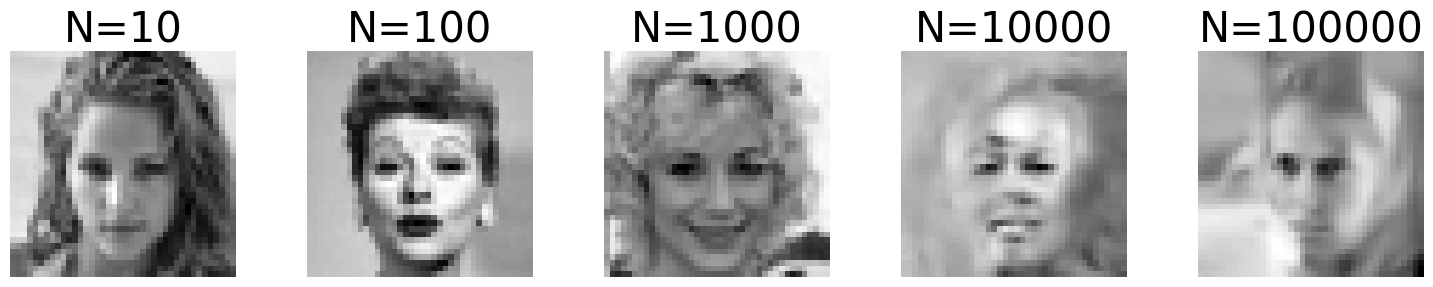

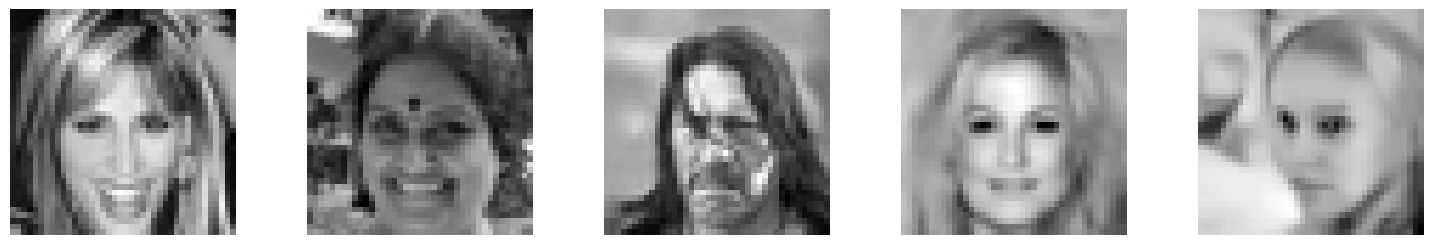

In [89]:

group = 'A'
show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='',sub_labels= ['N='+str(N) for N in denoisers_face[group].keys()] , n_columns=5)
group = 'B'
show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='',sub_labels= ['']*5 , n_columns=5)


In [90]:
closest_train = {}
for group in groups: 
    closest_train[group] = []
    for N in Ns:
        corrs = im_set_corr(samples_faces[group][N].unsqueeze(0).to(device), 
                            train_face[group][N].to(device), remove_mean=True)
        values, indices = corrs.max(dim = 1)
        closest_train[group].append(train_face[group][N][indices.cpu()])

<Figure size 640x480 with 0 Axes>

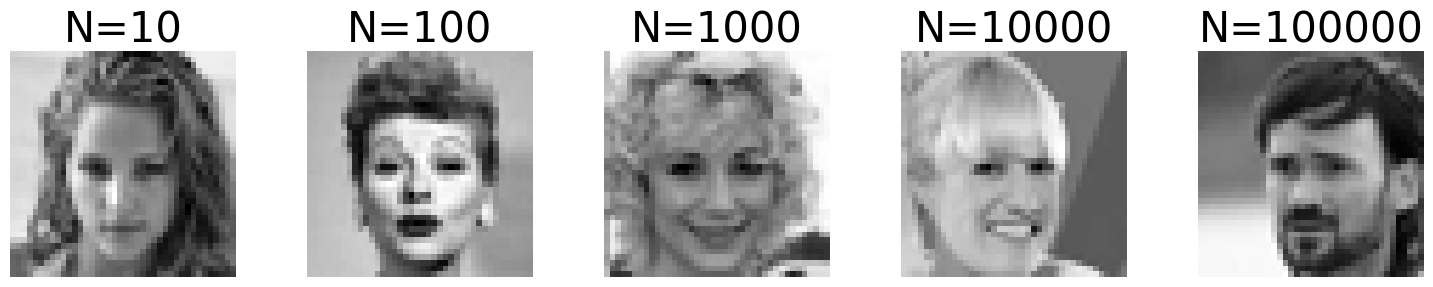

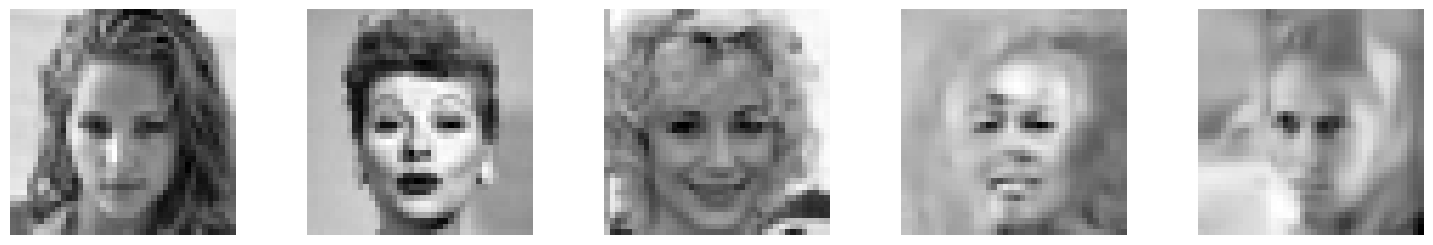

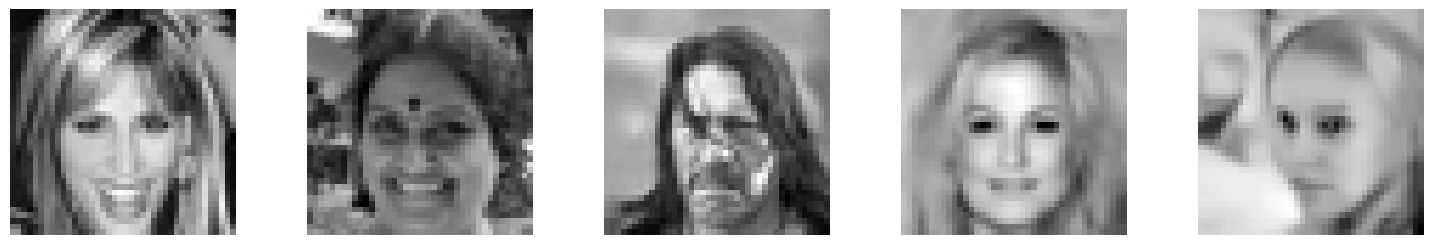

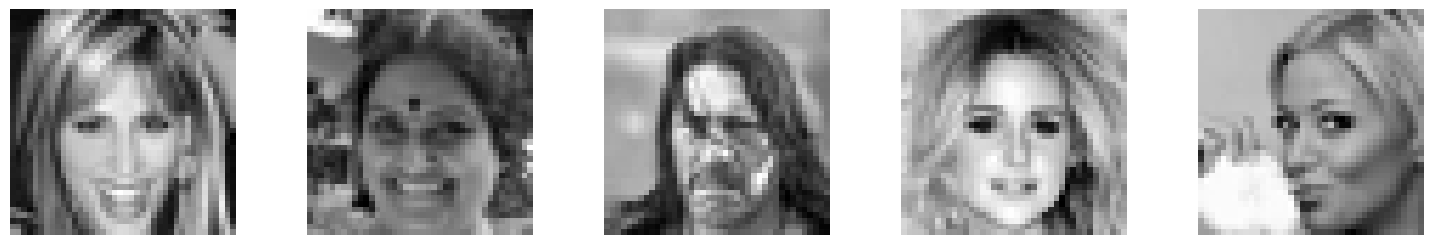

In [91]:
plt.figure()
group = 'A'
show_im_set(torch.vstack(closest_train[group]), label='',sub_labels= ['N='+str(N) for N in denoisers_face[group].keys()] , n_columns=5)
show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='',sub_labels= ['']*5, n_columns=5)

group = 'B'
show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='',sub_labels= ['']*5 , n_columns=5)
show_im_set(torch.vstack(closest_train[group]), label='',sub_labels= ['']*5 , n_columns=5);


In [92]:
more_closest_train = {}
for group in groups: 
    more_closest_train[group] = [[] for _ in range(10)]
    for i in range(10):
        more_closest_train[group][i] = []
        for N in Ns:
            corrs = im_set_corr(samples_faces[group][N].unsqueeze(0).to(device), 
                            train_face[group][N].to(device), remove_mean=True)
            values, indices = corrs.topk(10, dim = 1)
            closest_img = train_face[group][N][indices[0, i].cpu()]
            value = values[0, i].cpu().item()
            more_closest_train[group][i].append((closest_img, value))


In [75]:
plt.figure()
group = 'A'
for i in reversed(range(10)):
    images = [item[0] for item in more_closest_train[group][i]]
    corrs = [f"{item[1]:.3f}" for item in more_closest_train[group][i]]
    show_im_set(torch.stack(images), label=""*(i+1),sub_labels= corrs, n_columns=5)
show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='samples from group A',sub_labels= ['']*5, n_columns=5)

group = 'B'
show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='samples from group B',sub_labels= ['']*5 , n_columns=5)
for i in range(10):
    images = [item[0] for item in more_closest_train[group][i]]
    corrs = [f"{item[1]:.3f}" for item in more_closest_train[group][i]]
    show_im_set(torch.stack(images), label=""*(i+1),sub_labels= corrs , n_columns=5)

In [76]:
from tqdm import tqdm
import lpips
loss_fn_alex = lpips.LPIPS(net='alex')
loss_fn_vgg = lpips.LPIPS(net='vgg')

def prep_for_lpips(img): # img: [1, H, W] in [0, 1] → returns [3, H, W] in [-1, 1]
    if img.max() > 1.1:
        img = img / 255.0
    img_rgb = img.expand(3, -1, -1)
    return img_rgb * 2 - 1

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\sylva\Documents\Python\Inria\.inria\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: c:\Users\sylva\Documents\Python\Inria\.inria\lib\site-packages\lpips\weights\v0.1\vgg.pth


In [77]:
lpips_closest_train = {}
for group in groups: 
    lpips_closest_train[group] = [[] for _ in range(10)]
    for i in range(10):
        lpips_closest_train[group][i] = []
        for N in Ns:
            corrs = im_set_corr(samples_faces[group][N].unsqueeze(0).to(device), 
                            train_face[group][N].to(device), remove_mean=True)
            values, indices = corrs.topk(10, dim = 1)
            closest_img = train_face[group][N][indices[0, i].cpu()]
            value = values[0, i].cpu().item()
            lpips_closest_train[group][i].append((closest_img, value))

In [78]:
plt.figure()
group = 'A'

for i in reversed(range(10)):
    images = [item[0] for item in lpips_closest_train[group][i]]
    corrs = [f"{item[1]:.3f}" for item in lpips_closest_train[group][i]]

    samples = [samples_faces[group][N] for N in Ns]

    lpips_scores = []
    for gen_img, close_img in zip(samples, images):
        gen_ref   = prep_for_lpips(gen_img.cpu())
        close_rgb = prep_for_lpips(close_img.cpu())
        val = loss_fn_vgg(gen_ref.unsqueeze(0).to(device), close_rgb.unsqueeze(0).to(device))
        lpips_scores.append(f"{val.item():.3f}")

    show_im_set(torch.stack(images), label=""*(i+1),sub_labels=[f"corr={c}\nlpips={l}" for c, l in zip(corrs, lpips_scores)], n_columns=5)

show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='samples from group A',sub_labels= ['']*5, n_columns=5)

group = 'B'

show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='samples from group B',sub_labels= ['']*5 , n_columns=5)

for i in range(10):
    images = [item[0] for item in lpips_closest_train[group][i]]
    corrs = [f"{item[1]:.3f}" for item in lpips_closest_train[group][i]]

    samples = [samples_faces[group][N] for N in Ns]

    lpips_scores = []
    for gen_img, close_img in zip(samples, images):
        gen_ref   = prep_for_lpips(gen_img.cpu())
        close_rgb = prep_for_lpips(close_img.cpu())
        val = loss_fn_vgg(gen_ref.unsqueeze(0).to(device), close_rgb.unsqueeze(0).to(device))
        lpips_scores.append(f"{val.item():.3f}")

    show_im_set(torch.stack(images), label=""*(i+1),sub_labels = [f"corr={c}\nlpips={l}" for c, l in zip(corrs, lpips_scores)], n_columns=5)


In [53]:
#Generate many samples from a pair of denoisers trained on N images 
N = 100000
n_samples = 20
shift = 0
seeds = range(shift,shift+n_samples)
freq =10

all_samples = {}
all_interm_Ys = {}
all_sigmas={}
all_means = {}

start_time_total = time.time()
synth = synthesis()

for group in groups: 
    print('------------ group: ', group)
  
    all_samples[group] = torch.zeros(n_samples, 1, K,K).to(device)
    all_interm_Ys[group] = []
    all_sigmas[group] = []
    all_means[group] = [] 
    
    for n in range(n_samples): 
        print('--------- N : ', N)        
        torch.manual_seed(seeds[n])
        sample, interm_Ys,sigmas, means =univ_inv_sol(denoisers_face[group][N], 
                                                             x_c= torch.zeros(1,K,K),
                                                             task=synth,
                                                             device=device,
                                                             sig_0=1, 
                                                             sig_L=.1, 
                                                             h0=.01 , 
                                                             beta=.1 , 
                                                             freq=freq,
                                                             seed = seeds[n], 
                                                             init_im = train_face[group][N].mean(dim=0) + torch.randn(1,K,K, device = device), 
                                                             init_noise_mean=0,
                                                             max_T=10000, 
                                                             fixed_h=False)
        all_samples[group][n, 0] = sample.detach()
        all_interm_Ys[group].append(interm_Ys)
        all_sigmas[group].append(sigmas)
        all_means[group].append(means)
        
print("--- %s seconds ---" % (time.time() - start_time_total))

------------ group:  A
--------- N :  100000
----------------------------- 10
sigma  1.1061229705810547
mean  0.4421089291572571
----------------------------- 20
sigma  0.9832757711410522
mean  0.3524647653102875
----------------------------- 30
sigma  0.7946731448173523
mean  0.35780173540115356
----------------------------- 40
sigma  0.5197373032569885
mean  0.3985830545425415
----------------------------- 50
sigma  0.35607582330703735
mean  0.4101203680038452
----------------------------- 60
sigma  0.2222878634929657
mean  0.39516448974609375
----------------------------- 70
sigma  0.12354779243469238
mean  0.39107590913772583
-------- final sigma,  0.09468899667263031
-------- final mean  0.392976850271225
-------- total number of iterations,  74 -------- average time per iteration (s),  0.0233
--------- N :  100000
----------------------------- 10
sigma  1.0850883722305298
mean  0.426580548286438
----------------------------- 20
sigma  1.0221458673477173
mean  0.48044613003730774


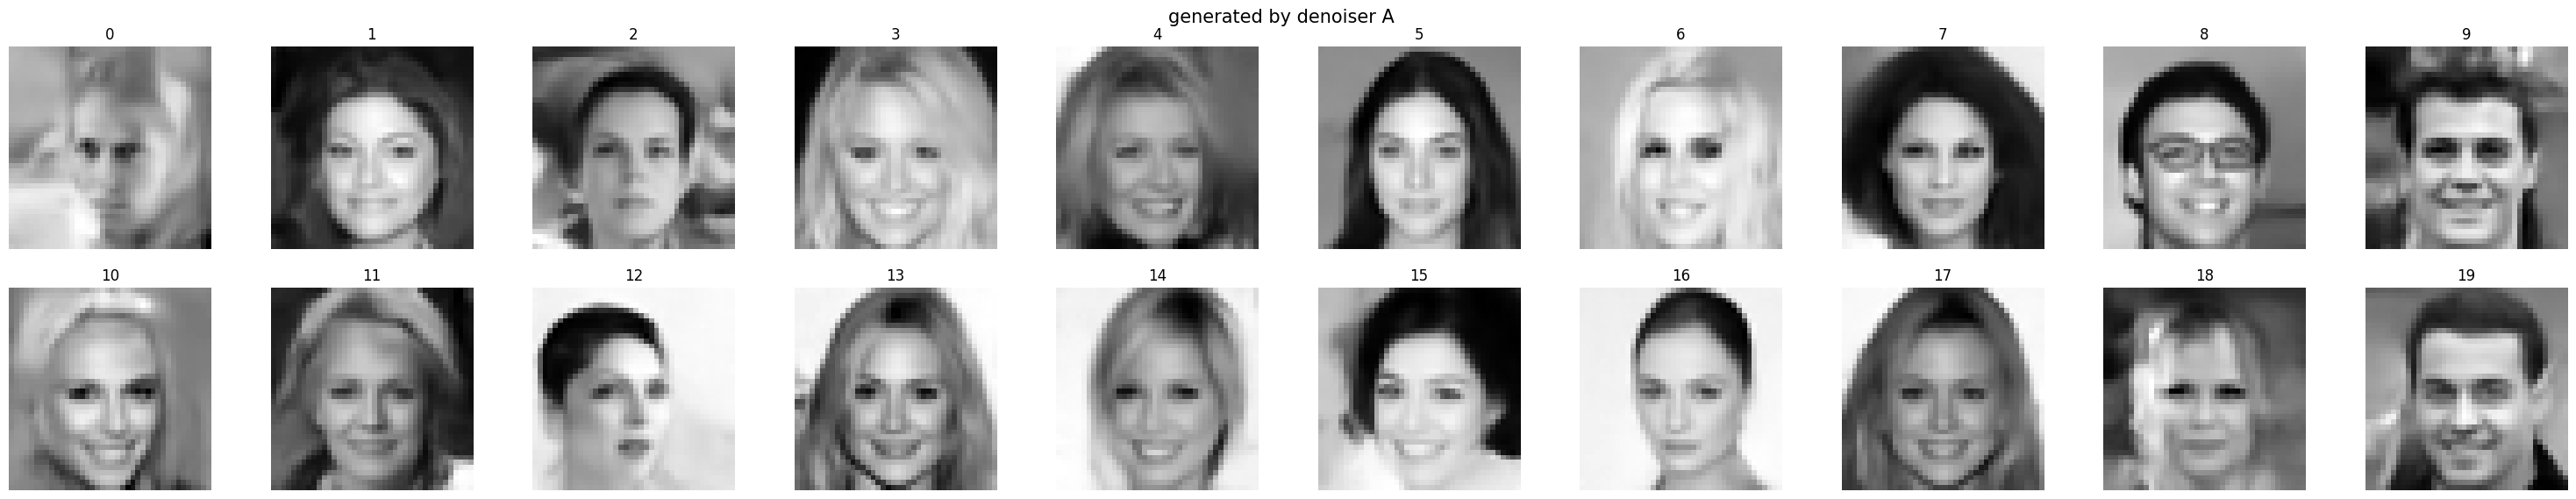

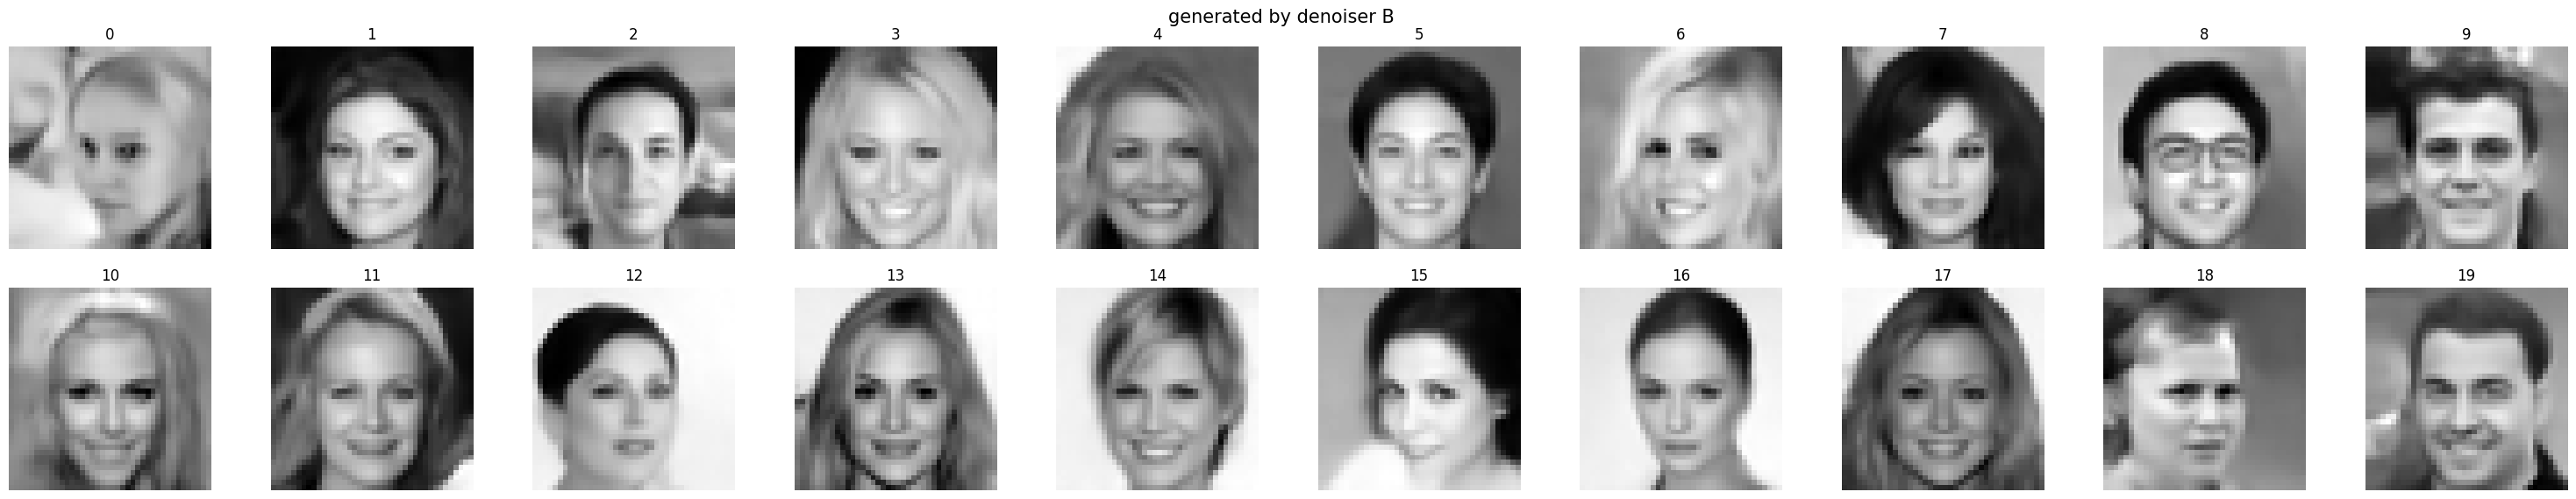

In [54]:
show_im_set(all_samples['A'], n_columns=10 , label='generated by denoiser A')
show_im_set(all_samples['B'], n_columns=10 , label='generated by denoiser B')